In [4]:
from datasets import load_dataset

# Load test split
ds = load_dataset("wltjr1007/Camelyon17-WILDS", split="test")

# Remove centers 0 and 1 (Radboud and Utrecht, from Camelyon16)
ds_filtered = ds.filter(lambda example: example["center"] not in [0, 1])

print(ds)
print(ds_filtered)


Dataset({
    features: ['image', 'label', 'center', 'image_id', 'patient', 'node', 'x_coord', 'y_coord', 'slide'],
    num_rows: 85054
})
Dataset({
    features: ['image', 'label', 'center', 'image_id', 'patient', 'node', 'x_coord', 'y_coord', 'slide'],
    num_rows: 85054
})


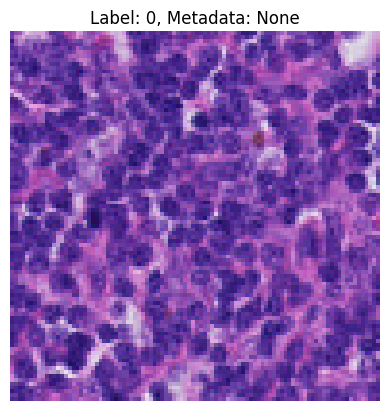

In [5]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

# Get one sample (dictionary) from test split
sample = ds[0]
x = sample["image"]       # image
y = sample["label"]       # label
metadata = sample.get("metadata", None)  # metadata if available

# Convert to PIL if needed
if not isinstance(x, Image.Image):
    x = transforms.ToPILImage()(x)

# Show the image
plt.imshow(x)
plt.title(f"Label: {y}, Metadata: {metadata}")
plt.axis("off")
plt.show()


In [6]:
import yaml
import torch
import torch.nn as nn
import torchvision.models as models


config = {
    "seed": 1337,
    "n_seeds": 3,
    "device": "cuda:0",
    "deterministic": True,

    "data": {
        "dataset_version": "pcam_v1",
        "splits_file": "splits/patient_level_fold0.json",
        "img_size": 128,
        "normalize": {"mean": [0.485, 0.456, 0.406], "std": [0.229, 0.224, 0.225]},
        "decode": "pillow_rgb",
        "stain_norm": "none",
        "augment": {
            "train": [
                {"hflip": 0.5},
                {"vflip": 0.5},
                {"color_jitter": {"b": 0.2, "c": 0.2, "s": 0.2}},
                {"blur": {"p": 0.2, "k": 3}},
            ],
            "val": []
        },
        "sampler": "random",
        "samples_per_epoch": None,
    },

    "loader": {
        "batch_size": 64,
        "grad_accum": 1,
        "num_workers": 4,
        "pin_memory": True,
        "persistent_workers": True,
    },

    "model": {
        "backbone": "densenet121",
        "weights": "imagenet_v1",
        "precision": "fp32",
        "dropout": 0.0,
        "freeze_backbone": False,
    },

    "objective": {
        "loss": "bce_logits",
        "pos_weight": None,
        "label_smoothing": 0.0,
        "focal": {"enable": False, "alpha": 0.25, "gamma": 2.0},
        "clip_grad_norm": None,
        "calibration": {"enable": False},
        "decision_threshold": 0.5,
        "tta": {"enable": False},
    },

    "optim": {
        "name": "adamw",
        "lr": 3.0e-4,
        "weight_decay": 1.0e-4,
        "betas": [0.9, 0.999],
        "schedule": "cosine",
        "t_max": 30,
        "warmup_steps": 0,
        "epochs": 10,
        "ema": {"enable": False, "decay": 0.999},
    },

    "eval": {
        "metrics": ["roc_auc", "pr_auc", "acc", "f1"],
        "ci_bootstrap": 2000,
        "select_best_by": "roc_auc",
        "eval_every": "epoch",
    },

    "env": {
        "torch": "2.3.1",
        "torchvision": "0.18.1",
        "cuda": "12.1",
        "cudnn_deterministic": True,
        "cublas_workspace": ":4096:8",
    }
}

# Save to YAML
with open("experiment.yaml", "w") as f:
    yaml.dump(config, f, sort_keys=False)

print("✅ experiment.yaml file created")

with open("experiment.yaml", "r") as f:
    cfg = yaml.safe_load(f)

device = torch.device(cfg["device"] if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


✅ experiment.yaml file created
Using device: cuda:0


In [7]:

# -----------------------------
# Load Trained Model
# -----------------------------
cfg_model = cfg["model"]

# Recreate model architecture
if cfg_model["backbone"] == "densenet121":
    model = models.densenet121(weights=None)  # No pretrained weights needed for inference
    model.classifier = nn.Sequential(
        nn.Dropout(cfg_model["dropout"]),
        nn.Linear(model.classifier.in_features, 1)
    )
else:
    raise NotImplementedError(f"Backbone {cfg_model['backbone']} not implemented")

# Load trained weights
model_path = "/kaggle/input/densenet_pcam/pytorch/default/1/densenet121_chunked.pth"  # or "densenet121_best.pth"
try:
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"✅ Model loaded from {model_path}")
except FileNotFoundError:
    print(f"❌ Model file {model_path} not found. Please train the model first.")
    exit()

model = model.to(device)
model.eval()

✅ Model loaded from /kaggle/input/densenet_pcam/pytorch/default/1/densenet121_chunked.pth


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score
from tqdm import tqdm
from PIL import Image

device = cfg["device"]

class HFDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, img_size=128, mean=None, std=None):
        self.dataset = hf_dataset
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        sample = self.dataset[idx]
        x = sample["image"]
        y = sample["label"]
        
        # Convert to PIL RGB to ensure 3 channels
        if not isinstance(x, Image.Image):
            x = transforms.ToPILImage()(x)
        x = x.convert("RGB")   # ✅ force 3 channels
        
        x = self.transform(x)
        return x, torch.tensor(y, dtype=torch.float32)


# Create dataset wrapper
mean = cfg["data"]["normalize"]["mean"]
std = cfg["data"]["normalize"]["std"]
test_dataset = HFDatasetWrapper(ds, img_size=cfg["data"]["img_size"], mean=mean, std=std)

# Create DataLoader
test_loader = DataLoader(
    test_dataset,
    batch_size=cfg["loader"]["batch_size"],
    shuffle=False,
    num_workers=cfg["loader"]["num_workers"],
    pin_memory=cfg["loader"]["pin_memory"]
)


In [9]:
# -----------------------------
# Evaluation Loop
# -----------------------------
all_labels = []
all_probs = []
all_preds = []

model.eval()
with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Evaluating"):
        x, y = x.to(device), y.to(device)
        logits = model(x).squeeze(1)
        probs = torch.sigmoid(logits)
        preds = (probs > cfg["objective"]["decision_threshold"]).long()
        
        all_labels.extend(y.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

Evaluating: 100%|██████████| 1329/1329 [01:10<00:00, 18.97it/s]


In [10]:
# -----------------------------
# Compute metrics
# -----------------------------
labels = all_labels
probs = all_probs
preds = all_preds

roc_auc = roc_auc_score(labels, probs)
pr_auc = average_precision_score(labels, probs)
acc = accuracy_score(labels, preds)
f1 = f1_score(labels, preds)

print(f"✅ Test ROC-AUC: {roc_auc:.4f}")
print(f"✅ Test PR-AUC: {pr_auc:.4f}")
print(f"✅ Test Accuracy: {acc:.4f}")
print(f"✅ Test F1 Score: {f1:.4f}")

✅ Test ROC-AUC: 0.9952
✅ Test PR-AUC: 0.9959
✅ Test Accuracy: 0.9678
✅ Test F1 Score: 0.9670


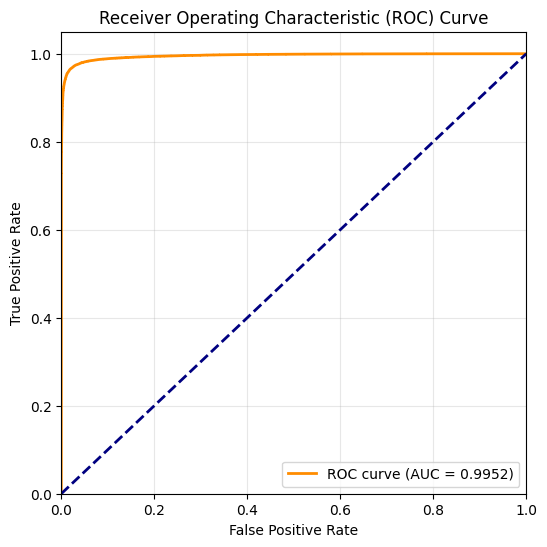

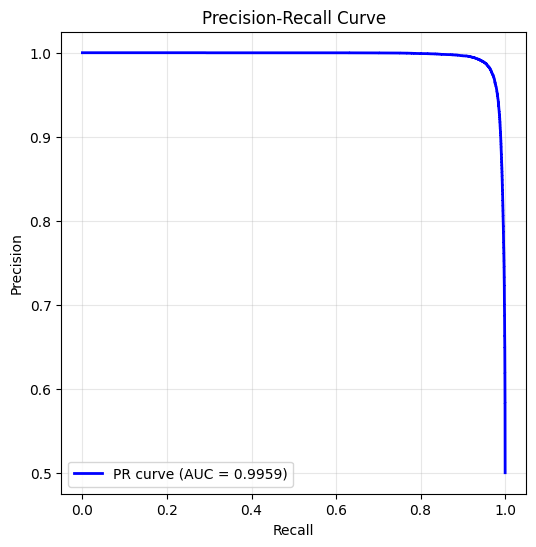

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import numpy as np

# Convert to numpy arrays
y_true = np.array(all_labels)
y_scores = np.array(all_probs)

# -----------------------------
# ROC Curve
# -----------------------------
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# -----------------------------
# Precision-Recall Curve
# -----------------------------
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()
